In [1]:
import os
from collections import defaultdict


root = '/media/bramiozo/DATA-FAST/kaggle/image_classification/MEDICAL/melanoma'
os.chdir(root)

num_gpu = 1
use_cpu = False
begin_resize = False
stride = 280
map_sel = 2 
num_classes=2
smart_mean = True
debug = True

run_settings = defaultdict(dict)
run_settings['resize'] = {'resize': (300, 300), 'scan_res': 290, 'randomcrop': None, 'centercrop': None, 
                          'stride': 280, 'TTA': 3, 'proba_aggregation': 'mean_softmax',
                          'use_inference_weights': False}
run_settings['centercrop'] = {'resize': None, 'scan_res': 290, 'randomcrop': (400,300), 'centercrop': None,
                              'stride': 280, 'TTA': 3, 'proba_aggregation': 'mean_softmax',
                              'use_inference_weights': False}

modelloc_dict = defaultdict(dict)
#modelloc_dict['efficient_net_b0']['resize'] = '../_models/melanoma/tf_efficientnet_b0_ns_DepthALL_40epochs_lastALLlayers_resized_balancingWsampler_batchsize32_optimizerAdaTuneAdam_numClass2_weightedLoss_wAugmentation_res300x300_datTRAINING_1024_BINOMIAL_numGPU1_cross_entropy.pyth'
modelloc_dict['efficient_net_b0']['resize'] = '../_models/melanoma/good/tf_efficientnet_b0_ns_DepthALL_60epochs_lastALLlayers_resized_balancingWsampler_batchsize32_optimizerAdaTuneAdam_numClass2_weightedLoss_wAugmentation_res300x300_datTRAINING_1024_BINOMIAL_numGPU1_cross_entropy_lr1e-4.pyth'
image_loc_train = 'TRAINING_1024_BINOMIAL'
image_loc_test = 'TRAINING_1024/TEST'

#load_from_disk = True
emb_agg_type = 'mean' # mean, stack, mean_var
final_agg = 'mean' # mean, smart_mean, log_mean
visualise_embeddings = True
write_to_disk = False
get_scoring = True
tabnet=False
calibrated_classifier=False

rolling_agg = False
# TODO introduce rolling aggregations. WHY? to avoid accumulating memory requirements during TTA! 

In [1]:
def smart_mean(x):    
    xw = np.abs(x.values - 0.5)     
    wm = np.dot(x.values.T, xw)
    if x.shape[1]>1:        
        return pd.Series(np.diag(wm), index=x.columns)/np.sum(xw)
    else:
        return wm[0][0]/np.sum(xw)
    
def log_mean(x):
    return np.exp(np.mean(np.log(x)))

# Goal

* extract image embeddings from CNN's 
* combine with meta features
* create new ensemble of models.

https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c

https://github.com/christiansafka/img2vec/blob/master/img2vec_pytorch/img_to_vec.py

This notebook **should** be structured as follows:
1. extract embeddings for the training, TTA_training
2. aggregate OR concatenate the training embeddings
3. join the training embeddings with the metadata
4. train TWO models: 1. embeddings+metadata, 2. only the embeddings
5. apply the models on the test-images with TTA_test
6. aggregate the results, write to file
7. do this for all models. 

In [2]:
import numpy as np
import pandas as pd
import sys
import random
import gc

import pydicom
import skimage
import albumentations
import cv2
from torchvision import transforms

import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.utils import *

from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import get_image_backend

from torch.autograd import Variable

from PIL import Image, ImageEnhance, ImageOps

import natsort

from torchvision import models
torchvision_models = dir(models)

from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
class WrappedModel(nn.Module):
    def __init__(self, module):
        super(WrappedModel, self).__init__()
        self.module = module # that I actually define.
    def forward(self, x):
        return self.module(x)

class Tinterpolate:
    def __init__(self, size, random_resize_crop=False):
        self.size = size
        self.rnd_resize_crop = random_resize_crop
    def __call__(self, x):
        if self.rnd_resize_crop:
            return TF.to_tensor(TF.RandomResizedCrop(TF.to_pil_images(x), size=self.size))
        else:
            return TF.to_tensor(TF.resize(TF.to_pil_image(x), size=self.size))

# credits: https://www.kaggle.com/c/siim-isic-melanoma-cp=0.5, num_holes=8, max_h_size=8, max_w_size=8lassification/discussion/159476
# credits: https://www.kaggle.com/allunia/don-t-turn-into-a-smoothie-after-the-shake-up
def random_microscope(img):
    circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        np.random.randint(img.shape[0]//1.75 - 1, img.shape[0]//1.75 + 15), # radius
                        (0, 0, 0), # color
                        -1)

    mask = circle - 255
    img = np.multiply(img, mask)
    return img

class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        img = np.asarray(img)
        if np.random.random() <self.p:
            img = random_microscope(img)
        img = Image.fromarray(np.uint8(img))
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

class AutoContrast:
    def __init__(self, p: float= 0.5, cutoff: float = 0.2):
        self.p = p
        self.cutoff = cutoff

    def __call__(self, img):
        if np.random.random() < self.p:
            return ImageOps.autocontrast(img, cutoff=self.cutoff)
        else:
            return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

class Equalize:
    def __init__(self, p: float= 0.5):
        self.p = p


    def __call__(self, img):
        if np.random.random() < self.p:
            return ImageOps.equalize(img)
        else:
            return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

class Sharpness:
    def __init__(self, p: float= 0.5, magnitude: int=3):
        self.p = p
        self.magnitude = magnitude
        self.magnitudes = np.linspace(0.1, 1.9, 11)

    def __call__(self, img):
        if np.random.random() < self.p:
            return ImageEnhance.Sharpness(img)\
                                .enhance(np.random.uniform(self.magnitudes[self.magnitude],
                                                        self.magnitudes[self.magnitude+1]))
        else:
            return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

# albumentations.augmentations.transforms.Cutout(num_holes=5,
#max_h_size=32, max_w_size=32, fill_value=0, always_apply=False, p=0.2)
#from albumentations.augmentations.transforms import Cutout as AlbCutout

class CutOut():
    def __init__(self, p: float=0.5, min_holes: int=2, max_holes: int=6,
                 fill_value: int=0, max_height: int=32, max_width: int=32,
                 min_height: int=8, min_width: int=8):
        self.p = p
        self.min_holes = min_holes
        self.max_holes = max_holes
        self.fill_value = fill_value
        self.max_height = max_height
        self.max_width = max_width
        self.min_height = min_height
        self.min_width = min_width

    def __call__(self, img):
        if np.random.random()<self.p:

            img = np.array(img)
            height, width = img.shape[:2]

            holes = []
            for _n in range(np.random.randint(self.min_holes, self.max_holes)):
                hole_height = np.random.randint(self.min_height, self.max_height)
                hole_width = np.random.randint(self.min_width, self.max_width)

                y1 = np.random.randint(0, height - hole_height)
                x1 = np.random.randint(0, width - hole_width)
                y2 = y1 + hole_height
                x2 = x1 + hole_width
                holes.append((x1, y1, x2, y2))

            res = albumentations.augmentations.transforms.F.cutout(img, holes, self.fill_value)
            return res # return Image.fromarray(res)
        else:
            return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'
    
class TestDataSet(Dataset):
    # https://discuss.pytorch.org/t/how-does-concatdataset-work/60083
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs) # natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, img_loc

class ImageFolderWithPaths(datasets.ImageFolder):    
    # https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [4]:
# dataloader stuffs
#
def create_loader(image_loc, ds_type = 'test', **kwargs):
    centercrop = kwargs['centercrop']
    randomcrop = kwargs['randomcrop']
    resize = kwargs['resize']
    
    img_transforms = [
                              transforms.RandomGrayscale(p=0.1),
                              Equalize(p=0.2),
                              AutoContrast(p=0.4, cutoff=0.2),
                              Sharpness(p=0.1, magnitude=3),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomVerticalFlip(),
                              transforms.RandomAffine(degrees=60,
                                                      translate=(0.05, 0.05),
                                                      shear=15,
                                                      resample=Image.BILINEAR),
                              transforms.ColorJitter(brightness=0.25, contrast=0.15,
                                                    saturation=0.15, hue=0.15),
                              Microscope(p=0.4),
                              CutOut(p=0.5, min_holes=8, max_holes=24,
                                 fill_value=0, max_height=32, max_width=32,
                                    min_height=16, min_width=16)
                              ]
    transform_list = img_transforms + [
                     transforms.ToTensor(),
                     transforms.RandomErasing(p=0.3, scale=(0.025, 0.05),
                                              ratio=(0.05, .1), value=0, inplace=False),
                     transforms.RandomErasing(p=0.2, scale=(0.025, 0.05),
                                              ratio=(4, 10), value=0, inplace=False),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225],)]

    if begin_resize:
        opt = [transforms.CenterCrop(centercrop)] if centercrop is not None \
                                                  else [transforms.Resize(randomcrop[0]),
                                                        transforms.RandomCrop(randomcrop[1],
                                                                              padding=0,
                                                                              pad_if_needed=True)] \
                                                    if randomcrop is not None \
                                                        else [resizer]
        transform_list = opt + transform_list
    else:
        opt = [transforms.ToPILImage(), transforms.CenterCrop(centercrop), transforms.ToTensor()] \
                                if centercrop is not None \
                                    else [transforms.ToPILImage(),
                                          transforms.Resize(randomcrop[0]),
                                          transforms.RandomCrop(randomcrop[1],
                                                                padding=0,
                                                                pad_if_needed=True),
                                          transforms.ToTensor()] \
                                        if randomcrop is not None \
                                        else [Tinterpolate(resize, False)]
        transform_list = transform_list + opt


    transformer = transforms.Compose(transform_list)

    if ds_type == 'test':
        dataset = TestDataSet(image_loc, transform=transformer)
    else:
        # datasets.ImageFolder(root = image_loc, transform=transformer)
        dataset = ImageFolderWithPaths(root = image_loc, transform=transformer)
    
    if ds_type == 'train':
        class_inds = dataset.class_to_idx    
        print("Class indices: {}".format(class_inds))
        target_vector = np.array(dataset.targets)
        class_counts = np.array([np.count_nonzero(target_vector==i, axis=0) for i in range(np.max(target_vector)+1)])
        class_weights = np.sqrt(1/class_counts)
        class_weights = np.around(class_weights/np.min(class_weights))
        num_classes = len(class_inds)

        class_weights_full_np = np.array([class_weights[_t] for _t in target_vector])
        class_weights_full = torch.DoubleTensor(class_weights_full_np).to(device)
        sampler = torch.utils.data.sampler.WeightedRandomSampler(class_weights_full, 
                                                                 len(target_vector),
                                                                 replacement=True)
    else:
        sampler = None
        
    return torch.utils.data.DataLoader(dataset, 
                                       num_workers = 16,
                                       shuffle = False,
                                       sampler =  sampler,
                                       drop_last = False, 
                                       pin_memory = True if device=='cuda:0' else False)



In [5]:
gpu_str = ",".join([str(i) for i in range(num_gpu)])
gpu_str = "" if use_cpu else gpu_str
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_str
GPU_COUNT = torch.cuda.device_count() 

if GPU_COUNT>1:
    device = torch.device("cuda" if (torch.cuda.is_available()) and (use_cpu==False) else "cpu")
else:
    device = torch.device("cuda:0" if (torch.cuda.is_available()) and (use_cpu==False) else "cpu")
    
if num_gpu>GPU_COUNT:
    raise Exception("We see only {} instead of {} GPU's".format(GPU_COUNT, num_gpu))
    
if torch.cuda.is_available():
    print("{} GPU's Detected".format(GPU_COUNT))
else:
    print("GPU is NOT detected!")

1 GPU's Detected


In [6]:
def create_model_dict(modelloc_dict):
    model_dict = defaultdict(lambda: defaultdict(object))
    for _arch, m in modelloc_dict.items():
        for _traintype in m.keys():        
            try:
                model = torch.load(modelloc_dict[_arch][_traintype], 
                                   map_location=torch.device(str(device))) 
                for _p in model.named_children():
                    pass            
            except:
                try:
                    print('load model..')
                    model = torch.load(modelloc_dict[_arch][_traintype], 
                                       map_location=torch.device(str(device)))    
                    model = WrappedModel(model.module)
                    print('load model...')
                    _mod = torch.load(modelloc_dict[_arch][_traintype], 
                                      map_location=torch.device(str(device)))
                    _mod.module.eval()
                    print('loading weights...')
                    state_dict = _mod.module.state_dict()
                    #state_dict.pop('_fc.weight')
                    #state_dict.pop('_fc.bias')

                    if num_gpu>1:
                        model= nn.DataParallel(model)        
                    model.to(device)

                    model.module.load_state_dict(state_dict)
                    #num_classes = model.module._fc.out_features
                except Exception as e:
                    print("Failed strategy 1, {}".format(e))    
                    try:            
                        model = torch.load(modelloc_dict[_arch][_traintype], 
                                           map_location=torch.device(str(device)))
                        model = WrappedModel(model.module)

                        if num_gpu>1:
                            model= nn.DataParallel(model) 
                        model.to(device)           

                        model.module.load_state_dict(torch.load(modelloc_dict[_arch][_traintype]),
                                                     map_location=torch.device(str(device)))
                        #num_classes = model.module._fc.out_features
                    except Exception as e:                
                        print("Problem loading model!, {}".format(e))

            model_dict[_arch][_traintype]= model
    return model_dict

In [7]:
model_dict = create_model_dict(modelloc_dict)

In [8]:
loader_dict = defaultdict(lambda : defaultdict(object))
for _arch, _kwargs in run_settings.items():
    loader_dict['test'][_arch] = create_loader(image_loc_test, ds_type='test', **_kwargs)
    loader_dict['train'][_arch] = create_loader(image_loc_train, ds_type='train', **_kwargs)

Class indices: {'no_mel': 0, 'yes_mel': 1}
Class indices: {'no_mel': 0, 'yes_mel': 1}


In [9]:
def get_feature_extractor(model):
    try:
        feature_extractor = model.module
    except:
        feature_extractor = model
    if 'efficientnet' in str(type(feature_extractor)).lower():
        print('Replace sequential layer in EfficientNet')
        feature_extractor.classifier = nn.Sequential() # .classifier for EffNet, head.fc for RegNet
    elif 'regnet' in str(type(feature_extractor)).lower(): 
        print('Replace sequential layer in RegNet')
        feature_extractor.head.fc = nn.Sequential() # .classifier for EffNet, head.fc for RegNet    
    return feature_extractor

In [10]:
def get_embedding(feature_extractor, img):
    return feature_extractor(img.to(device)).detach().to('cpu').numpy()

# Populating an array with the Test image embeddings


In [11]:
def model_run(model, num_classes, data_loader, _archname, traintype, rolling_agg, ds_type='test', **kwargs):   
    '''
         rolling_agg only supports mean atm
    '''
    
    TTA = kwargs['TTA']
    use_inference_weights = kwargs['use_inference_weights']
    
    res_list = []
    model.eval()
    #class_count = defaultdict(int)
    proba_sum = 0
    with torch.no_grad():
        for _m in range(TTA):
            print("Starting on TTA round {}".format(_m))
            for idx, data in tqdm(enumerate(data_loader, 0)):
                # 
                # get image size tuple
                im_size = data[0].shape
                im_loc = data[-1]
                im_name = im_loc[0].split("/")[-1].strip("\.jpg")
                try:
                    results = get_embedding(model, data[0])
                except Exception as e:
                    print("Convolving inference failed: {}. On image: {}".format(e, im_name))  
            
                _res = results[0,:]                
                
                #if (rolling_agg) and (_m>0):
                # need to update dictionary
                
                
                tdict = dict(zip(['emb_'+str(i) for i in range(results.shape[1])], 
                                                           list(_res)))
                tdict['image_name'] =im_name
                
                tdict['tta_run'] = _m
                if ds_type=='train':
                    tdict['img_target'] = data[1].numpy()[0]
                
                res_list.append(tdict)
                
                if (idx % 1000 == 999) & (debug==True) & (ds_type=='train'):
                    break
        
        
    # TODO add online mean
    # TODO add online std
    return pd.DataFrame(res_list)


In [12]:
def collect_embeddings(model_dict, loader_dict, ds_type='test', rolling_agg=False):
    cnt = 0
    df_dict = defaultdict(pd.DataFrame)
    for _archname in model_dict.keys():
        for _traintype, _model in model_dict[_archname].items():
            print("architecture: {}, traintype: {}".format(_archname, _traintype))
            feature_extractor = get_feature_extractor(_model)
            _kwargs = run_settings[_traintype]
            _res = model_run(feature_extractor,
                             num_classes,
                             loader_dict[_traintype],
                             _archname,
                             _traintype,
                             rolling_agg,
                             ds_type,                             
                             **_kwargs)
            df_dict["_".join([_archname, _traintype])] = _res
            cnt = cnt + 1
    gc.collect()
    return df_dict

In [13]:
def agg_df_dict(df_dict, agg_type='mean'):
    df_agg = defaultdict(object)
    for k,v in df_dict.items():
        if agg_type == 'mean':
            df_agg[k] = v.groupby('image_name').agg('mean')
            df_agg[k].drop('tta_run', axis=1, inplace=True)
        elif (agg_type is None) or (agg_type=='stack'):
            df_agg[k] = v.drop('tta_run', axis=1)
            df_agg[k].set_index('image_name', inplace=True)
        elif agg_type == 'mean_var':
            df_agg[k] = v.groupby('image_name').agg(np.nanmean)
            var_data = v.groupby('image_name').agg(np.nanstd)
            df_agg[k] = df_agg[k].join(var_data, rsuffix='_var') 
            df_agg[k].drop('tta_run', axis=1, inplace=True)
    return df_agg

## Extracting the test-image embeddings

In [14]:
test_embeddings_dict = collect_embeddings(model_dict, loader_dict['test'], rolling_agg)
if rolling_agg:
    test_embeddings_agg = test_embeddings_dict
else:
    test_embeddings_agg = agg_df_dict(test_embeddings_dict, agg_type=emb_agg_type)
gc.collect()

architecture: efficient_net_b0, traintype: resize
Replace sequential layer in EfficientNet
Starting on TTA round 0


10982it [03:50, 47.56it/s]

Starting on TTA round 1



10982it [04:15, 43.00it/s]

Starting on TTA round 2



10982it [03:45, 48.71it/s]


0

## Visualisation of Test image embeddings

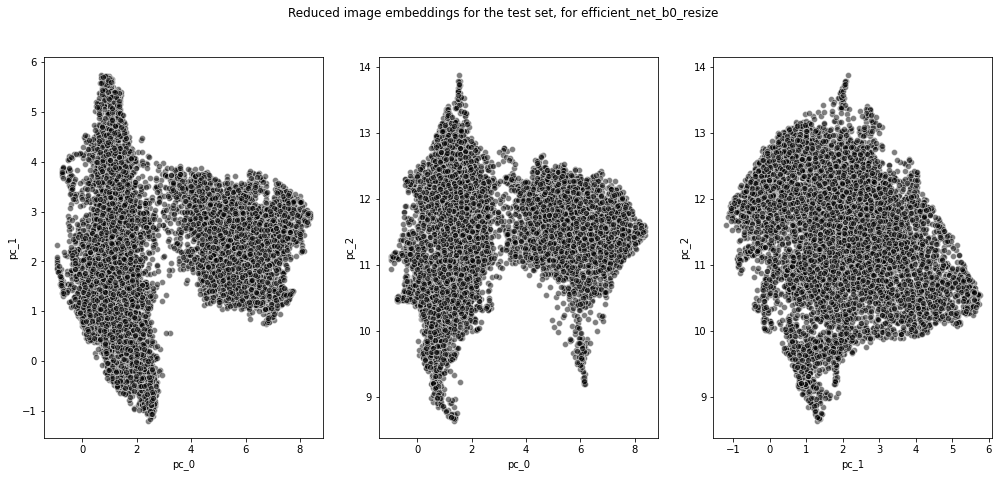

In [15]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from umap import UMAP
import gc

if visualise_embeddings:
    reducer = UMAP(n_components=3, random_state=42)
    scaler = RobustScaler()
    
    for k,v in test_embeddings_agg.items():
        emb_cols = [_col for _col in v.columns if 'emb_' in _col]
        v[emb_cols] = scaler.fit_transform(v[emb_cols])
        red_ = reducer.fit_transform(v[emb_cols])
        red_df = pd.DataFrame(data=red_, columns=['pc_'+str(i) for i in range(3)], index=v.index)
        red_df.reset_index(inplace=True)

        fig, ax = plt.subplots(ncols=3, figsize=(17, 7))
        sns.scatterplot(data=red_df, x='pc_0', y='pc_1', alpha=0.5, ax=ax[0], color='black')
        sns.scatterplot(data=red_df, x='pc_0', y='pc_2', alpha=0.5, ax=ax[1], color='black')
        sns.scatterplot(data=red_df, x='pc_1', y='pc_2', alpha=0.5, ax=ax[2], color='black')

        if emb_agg_type in ['mean']:
            tmp = test_embeddings[k]

            tmp[emb_cols] = scaler.transform(tmp[emb_cols])
            red_ = reducer.transform(tmp[emb_cols])
            red_df = pd.DataFrame(data=red_, columns=['pc_'+str(i) for i in range(3)], index=tmp.index)
            red_df.reset_index(inplace=True)

            sns.scatterplot(data=red_df, x='pc_0', y='pc_1', alpha=0.1, ax=ax[0], color='blue')
            sns.scatterplot(data=red_df, x='pc_0', y='pc_2', alpha=0.1, ax=ax[1], color='blue')
            sns.scatterplot(data=red_df, x='pc_1', y='pc_2', alpha=0.1, ax=ax[2], color='blue')
        
        fig.suptitle(f'Reduced image embeddings for the test set, for {k}')

In [16]:
def join_with_meta(embeddings, meta_df):
    meta_embeddings = defaultdict(object)
    for k, v in embeddings.items():
        meta_embeddings[k] = embeddings[k].join(meta_df, how='inner')
    return meta_embeddings

# Append metadata

In [17]:
meta_df = pd.read_csv("meta_enriched_prepped.csv", sep=";")
meta_df['filename'] = meta_df.filename.apply(lambda x: x.strip(".jpg"))
meta_df.set_index('filename', inplace=True)

In [18]:
df = meta_df[['sex', 'sites']]
meta_df[['sex', 'sites']] = df.fillna(df.mode().iloc[0])
meta_df.dropna(subset=['width','height'], how='any', inplace=True)

In [19]:
tmap = {
            'nv': 0,
            'anv': 0,
            'bkl': 0,
            'misc': 0,
            'df': 0,
            'scc': 0,
            'bcc': 0,
            'vasc': 0,
            'ak': 0,
            'mel': 1    
        }
meta_df['y'] = meta_df.target.map(tmap)
meta_df['y_2'] = meta_df.target_new.map(tmap)
meta_df['y'] = meta_df[['y', 'y_2']].apply(lambda x: x[0] if ~pd.isna(x[0]) else x[1], axis=1)
meta_df.drop('y_2', axis=1, inplace=True)

meta_df = meta_df.loc[(meta_df.set=='TEST') | ((meta_df.set=='TRAIN') & (~meta_df.y.isna()))]

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
encoder.fit(meta_df[['sex', 'sites']])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [20]:
test_embeddings_meta = join_with_meta(test_embeddings_agg, meta_df)
for k in test_embeddings_meta.keys():
    test_embeddings_meta[k].drop(['target', 'target_new', 'dataset', 'set', 'y'], axis=1, inplace=True)

In [21]:
# imputance
from sklearn.impute import SimpleImputer
for k,v in test_embeddings_meta.items():
    # impute with the most common value
    df = v[['sex', 'sites']]
    test_embeddings_meta[k][['sex', 'sites']] = df.fillna(df.mode().iloc[0]) 
    
    # impute with the mean
    cont_cols = [_c for _c in v.columns if _c not in ['sex', 'sites']]
    df = v[cont_cols]
    test_embeddings_meta[k][cont_cols] = df.fillna(df.mean())

In [22]:
# write to disc
if write_to_disk:
    for k,v in test_embeddings_dict.items():
        v.reset_index().to_feather('test_embedding_raw_'+k+'.feather')    

    for k,v in test_embeddings_meta.items():
        #v.to_parquet('test_embedding_meta_'+k+'.parquet.gzip', compression='gzip', engine='fastparquet')
        v.reset_index().to_feather('test_embedding_meta_'+k+'.feather')
    gc.collect()

del test_embeddings_dict
gc.collect()

22560

# Populating an array with the Train image embeddings


In [23]:
train_embeddings_dict = collect_embeddings(model_dict, loader_dict['train'], ds_type='train', rolling_agg=rolling_agg)
if rolling_agg:
    train_embeddings_agg = train_embeddings_dict
else:
    train_embeddings_agg = agg_df_dict(train_embeddings_dict, agg_type=emb_agg_type)

if write_to_disk:
    for k,v in train_embeddings_dict.items():
        v.reset_index().to_feather('train_embedding_raw_'+k+'.feather')    
    gc.collect()

architecture: efficient_net_b0, traintype: resize
Replace sequential layer in EfficientNet
Starting on TTA round 0


62888it [23:17, 45.01it/s]

Starting on TTA round 1



62888it [23:12, 45.15it/s]

Starting on TTA round 2



62888it [23:20, 44.90it/s]


In [24]:
#nan_rows = train_embeddings_agg['regnet_064_resize'].index[train_embeddings_agg['regnet_064_resize'].isna().sum(axis=1)>0]
#nan_cols = train_embeddings_agg['regnet_064_resize'].columns[train_embeddings_agg['regnet_064_resize'].isna().sum(axis=0)>0]

In [25]:
for k in train_embeddings_agg.keys():
    train_embeddings_agg[k].dropna(axis=0, inplace=True)

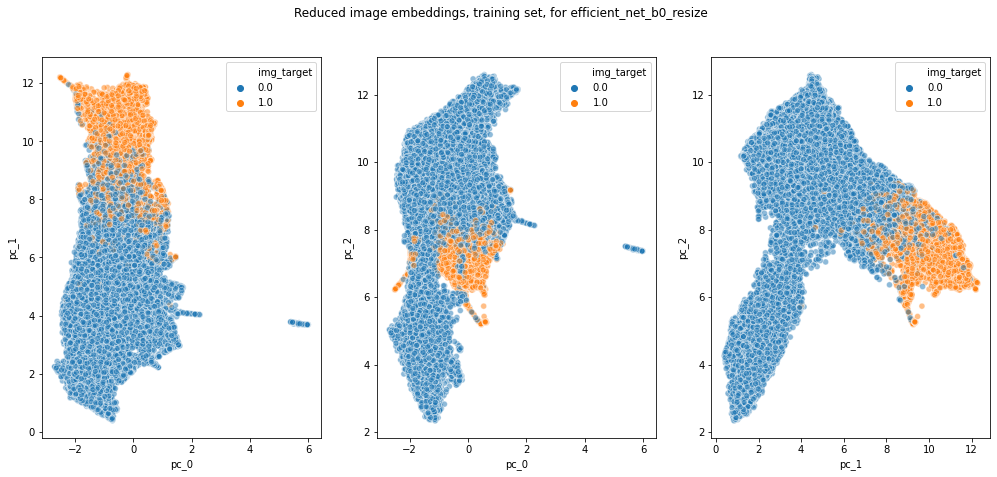

In [26]:
if visualise_embeddings:
    reducer = UMAP(n_components=3, random_state=42)
    scaler = RobustScaler()
    gc.collect()
    
    for k,v in train_embeddings_agg.items():
        emb_cols = [_col for _col in v.columns if 'emb_' in _col]
        v[emb_cols] = scaler.fit_transform(v[emb_cols])
        red_ = reducer.fit_transform(v[emb_cols])
        red_df = pd.DataFrame(data=red_, columns=['pc_'+str(i) for i in range(3)], index=v.index)
        red_df = red_df.join(v[['img_target']])
        red_df.reset_index(inplace=True)

        fig, ax = plt.subplots(ncols=3, figsize=(17, 7))
        sns.scatterplot(data=red_df, x='pc_0', y='pc_1', alpha=0.5, ax=ax[0], hue='img_target')
        sns.scatterplot(data=red_df, x='pc_0', y='pc_2', alpha=0.5, ax=ax[1], hue='img_target')
        sns.scatterplot(data=red_df, x='pc_1', y='pc_2', alpha=0.5, ax=ax[2], hue='img_target')
        
        if emb_agg_type in ['mean']:
            tmp = train_embeddings_dict[k]
            tmp[emb_cols] = scaler.transform(tmp[emb_cols])
            red_ = reducer.transform(tmp[emb_cols])
            red_df = pd.DataFrame(data=red_, columns=['pc_'+str(i) for i in range(3)], index=tmp.index)
            red_df.reset_index(inplace=True)

            sns.scatterplot(data=red_df, x='pc_0', y='pc_1', alpha=0.1, ax=ax[0], color='blue')
            sns.scatterplot(data=red_df, x='pc_0', y='pc_2', alpha=0.1, ax=ax[1], color='blue')
            sns.scatterplot(data=red_df, x='pc_1', y='pc_2', alpha=0.1, ax=ax[2], color='blue')
        
        fig.suptitle(f'Reduced image embeddings, training set, for {k}')

In [27]:
del train_embeddings_dict
gc.collect()

20

In [28]:
train_embeddings_meta = join_with_meta(train_embeddings_agg, meta_df)
if write_to_disk:
    for k,v in train_embeddings_meta.items():
        v.reset_index().to_feather('train_embedding_meta_'+k+'.feather')
gc.collect()

for k in train_embeddings_meta.keys():
    train_embeddings_meta[k].drop(['target_new', 'dataset', 'set'], axis=1, inplace=True)
    

In [29]:
# imputance
for k,v in train_embeddings_meta.items():
    # impute with the most common value
    df = v[['sex', 'sites']]
    train_embeddings_meta[k][['sex', 'sites']] = df.fillna(df.mode().iloc[0]) 
    
    # impute with the mean
    cont_cols = [_c for _c in v.columns if _c not in ['sex', 'sites']]
    df = v[cont_cols]
    train_embeddings_meta[k][cont_cols] = df.fillna(df.mean())

In [30]:
'''
for k in train_embeddings_meta.keys():
    train_embeddings_meta[k].loc[:, ['sex', 'sites']] = \
                    encoder.transform(train_embeddings_meta[k].loc[:, ['sex', 'sites']])
    
for k in test_embeddings_meta.keys():
    test_embeddings_meta[k].loc[:, ['sex', 'sites']] = \
                    encoder.transform(test_embeddings_meta[k].loc[:, ['sex', 'sites']]) 
'''

"\nfor k in train_embeddings_meta.keys():\n    train_embeddings_meta[k].loc[:, ['sex', 'sites']] =                     encoder.transform(train_embeddings_meta[k].loc[:, ['sex', 'sites']])\n    \nfor k in test_embeddings_meta.keys():\n    test_embeddings_meta[k].loc[:, ['sex', 'sites']] =                     encoder.transform(test_embeddings_meta[k].loc[:, ['sex', 'sites']]) \n"

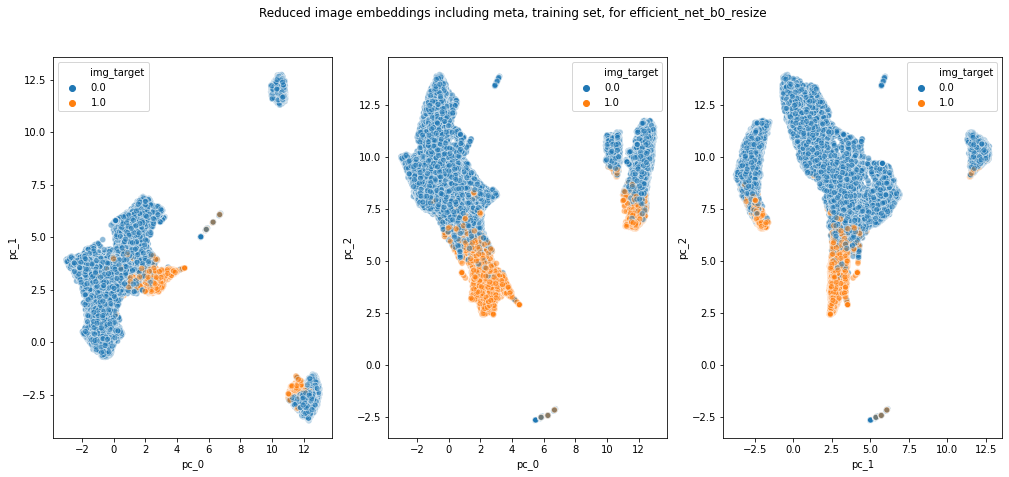

In [45]:
if visualise_embeddings:
    reducer = UMAP(n_components=3, random_state=42)
    scaler = RobustScaler()
    gc.collect()
    
    for k,v in train_embeddings_meta.items():
        var_cols = [_col for _col in v.columns if _col not in ['y', 'target', 'img_target']]
        v[var_cols] = scaler.fit_transform(v[var_cols])
        red_ = reducer.fit_transform(v[var_cols])
        red_df = pd.DataFrame(data=red_, columns=['pc_'+str(i) for i in range(3)], index=v.index)
        red_df = red_df.join(v[['img_target']])
        red_df.reset_index(inplace=True)

        fig, ax = plt.subplots(ncols=3, figsize=(17, 7))
        sns.scatterplot(data=red_df, x='pc_0', y='pc_1', alpha=0.5, ax=ax[0], hue='img_target')
        sns.scatterplot(data=red_df, x='pc_0', y='pc_2', alpha=0.5, ax=ax[1], hue='img_target')
        sns.scatterplot(data=red_df, x='pc_1', y='pc_2', alpha=0.5, ax=ax[2], hue='img_target')
        
        if emb_agg_type in ['mean']:
            tmp = train_embeddings_meta[k]
            tmp[emb_cols] = scaler.transform(tmp[var_cols])
            red_ = reducer.transform(tmp[var_cols])
            red_df = pd.DataFrame(data=red_, columns=['pc_'+str(i) for i in range(3)], index=tmp.index)
            red_df.reset_index(inplace=True)

            sns.scatterplot(data=red_df, x='pc_0', y='pc_1', alpha=0.1, ax=ax[0], color='blue')
            sns.scatterplot(data=red_df, x='pc_0', y='pc_2', alpha=0.1, ax=ax[1], color='blue')
            sns.scatterplot(data=red_df, x='pc_1', y='pc_2', alpha=0.1, ax=ax[2], color='blue')
        
        fig.suptitle(f'Reduced image embeddings including meta, training set, for {k}')

In [32]:
# remove image_target_var
try:
    for k in train_embeddings_meta.keys():
        train_embeddings_meta[k].drop(['img_target_var', 'tta_run_var'], axis=1, inplace=True)
        test_embeddings_meta[k].drop(['tta_run_var'], axis=1, inplace=True)

except:
    print("Tried removing image_target_var, ne pasaaaaa")

try:
    for k in train_embeddings_agg.keys():
        train_embeddings_agg[k].drop(['img_target_var', 'tta_run_var'], axis=1, inplace=True)
        test_embeddings_agg[k].drop(['tta_run_var'], axis=1, inplace=True)
except:
    print("Tried removing image_target_var, ne pasaaaaa")


## Train on image and meta data

In [33]:
from pytorch_tabnet.tab_model import TabNetClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV as ccv

In [ ]:
# TODO add regressor, add early stopping, add categoricals, add cross folding
# https://www.kaggle.com/ilosvigil/lgb-only-metadata-public-private-0-6524-0-7156
# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

In [46]:
#####################################################################
########################### train XGBoost ###########################
#####################################################################
xgb_dict = dict()
for k, v in train_embeddings_meta.items():  
    v['y'] = v['y'].astype(int)
    v['sex'] = v['sex'].astype(int)
    v['sites'] = v['sites'].astype(int)
    
    y = v['y']    
    X = v.drop(['y', 'target', 'img_target'], axis=1)
    if calibrated_classifier:
        clf = XGBClassifier(n_estimators=500, scale_pos_weight=10, n_jobs=16, base_score=0.02, verbose=3)
        xgb_dict[k] = ccv(clf, cv=5)
        xgb_dict[k].fit(X,y)
    else:
        xgb_dict[k] = XGBClassifier(n_estimators=500, scale_pos_weight=10, n_jobs=16, base_score=0.02, verbose=3)
        xgb_dict[k].fit(X,y)
    gc.collect()
    
# get scoring
get_scoring=False
if get_scoring:
    from sklearn.model_selection import cross_val_score, cross_validate
    for k, v in train_embeddings_meta.items():  
        v['y'] = v['y'].astype(int)
        v['sex'] = v['sex'].astype(int)
        v['sites'] = v['sites'].astype(int)

        y = v['y']    
        X = v.drop(['y', 'target', 'img_target'], axis=1)
        estimator = XGBClassifier(n_estimators=250, scale_pos_weight=10, base_score=0.02, n_jobs=-1)
        cvscores = cross_validate(estimator, X=X, y=y, cv=5,
                                   scoring=("roc_auc_ovr_weighted","roc_auc_ovr","recall"))
        print(f"{k} XGB CV scores:{cvscores}")
        gc.collect()

In [47]:
# apply to test set
# 
pred_list = []
for k, clf in xgb_dict.items():
    test_index = test_embeddings_meta[k].index
    pred = clf.predict_proba(test_embeddings_meta[k])    
    pred_list.append(pd.DataFrame(data=pred, columns=['non-mel', 'target'], index=test_index))

preds_xgb = pd.concat(pred_list, axis=0)
# aggregate results
preds_xgb.reset_index(inplace=True)

if final_agg=='mean':
    preds_xgb_final = preds_xgb.groupby('index').agg('mean')
elif final_agg=='smart_mean':
    preds_xgb_final = preds_xgb.groupby('index').apply(smart_mean)
elif final_agg=='log_mean':
    preds_xgb_final = preds_xgb.groupby('index').apply(log_mean)
    
preds_xgb_final.index.rename('image_name', inplace=True)
preds_xgb_final.drop('non-mel', axis=1, inplace=True)
preds_xgb_final.to_csv('xgb_final_results.csv', sep=",", index=True)

In [38]:
#####################################################################
########################### train TabNet ############################
#####################################################################

if tabnet:    
    from sklearn.model_selection import train_test_split
    tabn_dict = dict()
    for k, v in train_embeddings_meta.items():  

        train_indices, valid_indices = train_test_split(range(v.shape[0]), 
                                                       test_size=0.2, random_state=0)

        t = train_embeddings_meta[k].columns.tolist()
        sex_id = np.argwhere(np.array(t)=='sex')[0][0]
        sites_id = np.argwhere(np.array(t)=='sites')[0][0]   

        v['y'] = v['y'].astype(int)
        v['sex'] = v['sex'].astype(float)
        v['sites'] = v['sites'].astype(float)
        v['age'] = v['sex'].astype(float)

        y = v['y']    
        X = v.drop(['y', 'target', 'img_target'], axis=1)

        X_train, X_valid = X.values[train_indices], X.values[valid_indices]
        y_train, y_valid = y.values[train_indices], y.values[valid_indices]

        tabn_dict[k] = TabNetClassifier(cat_idxs=[sex_id, sites_id], 
                                        cat_dims=[2, 6],
                                        optimizer_fn=torch.optim.Adam,
                                        optimizer_params=dict(lr=2e-2),
                                        scheduler_params = {"gamma": 0.95,
                                                         "step_size": 20},
                                        scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15)
        tabn_dict[k].fit(X_train,y_train,X_valid,y_valid, max_epochs=20, patience=5,
        batch_size=256, virtual_batch_size=64)
        
    # apply to test set
    # 
    pred_list = []
    for k, clf in tabn_dict.items():
        test_index = test_embeddings_agg[k].index
        pred = clf.predict_proba(test_embeddings_agg[k])    
        pred_list.append(pd.DataFrame(data=pred, columns=['non-mel', 'target'], index=test_index))
        gc.collect()

    preds_tabn = pd.concat(pred_list, axis=0)
    # aggregate results
    preds_tabn.reset_index(inplace=True)
    preds_tabn_final = preds_tabn.groupby('image_name').agg('mean')
    preds_tabn_final.index.rename('image_name', inplace=True)
    preds_tabn_final.drop('non-mel', axis=1, inplace=True)
    preds_tabn_final.to_csv('tabnet_final_results.csv', sep=",", index=True)

## Train on image embeddings only

In [49]:
#####################################################################
########################### train XGBoost ###########################
#####################################################################
xgb_dict = dict()
for k, v in train_embeddings_agg.items():  
    v['img_target'] = v['img_target'].astype(int)
    y = v['img_target']    
    X = v.drop(['img_target'], axis=1)
    if calibrated_classifier:
        clf = XGBClassifier(n_estimators=500, scale_pos_weight=10, n_jobs=16, verbose=3)
        xgb_dict[k] = ccv(clf, cv=5)
        xgb_dict[k].fit(X,y)
    else:
        xgb_dict[k] = XGBClassifier(n_estimators=500, scale_pos_weight=10, n_jobs=16, verbose=3)
        xgb_dict[k].fit(X,y)
    gc.collect()

In [50]:
#####################
# apply to test set #
#####################
pred_list = []
for k, clf in xgb_dict.items():
    test_index = test_embeddings_agg[k].index
    pred = clf.predict_proba(test_embeddings_agg[k])    
    pred_list.append(pd.DataFrame(data=pred, columns=['non-mel', 'target'], index=test_index))

preds_xgb = pd.concat(pred_list, axis=0)
# aggregate results
preds_xgb.reset_index(inplace=True)
if final_agg=='mean':
    preds_xgb_final = preds_xgb.groupby('image_name').agg('mean')
elif final_agg=='smart_mean':
    preds_xgb_final = preds_xgb.groupby('image_name').apply(smart_mean)
elif final_agg=='log_mean':
    preds_xgb_final = preds_xgb.groupby('image_name').apply(log_mean)
    
preds_xgb_final.drop('non-mel', axis=1, inplace=True)
preds_xgb_final.to_csv('xgb_final_results_embeddingsOnly.csv', sep=",", index=True)

In [41]:
#####################################################################
########################### train TabNet ############################
#####################################################################

if tabnet:
    from sklearn.model_selection import train_test_split

    tabn_dict = dict()
    for k, v in train_embeddings_meta.items():  

        train_indices, valid_indices = train_test_split(range(v.shape[0]), 
                                                       test_size=0.2, random_state=0)

        t = train_embeddings_meta[k].columns.tolist()
        sex_id = np.argwhere(np.array(t)=='sex')[0][0]
        sites_id = np.argwhere(np.array(t)=='sites')[0][0]   

        v['y'] = v['y'].astype(int)
        v['sex'] = v['sex'].astype(float)
        v['sites'] = v['sites'].astype(float)
        v['age'] = v['sex'].astype(float)

        y = v['y']    
        X = v.drop(['y', 'target', 'img_target'], axis=1)

        X_train, X_valid = X.values[train_indices], X.values[valid_indices]
        y_train, y_valid = y.values[train_indices], y.values[valid_indices]

        tabn_dict[k] = TabNetClassifier(cat_idxs=[sex_id, sites_id], 
                                        cat_dims=[2, 6],
                                        optimizer_fn=torch.optim.Adam,
                                        optimizer_params=dict(lr=2e-2),
                                        scheduler_params = {"gamma": 0.95,
                                                         "step_size": 20},
                                        scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15)
        tabn_dict[k].fit(X_train,y_train,X_valid,y_valid, max_epochs=20, patience=5,
        batch_size=256, virtual_batch_size=64)

    # apply to test set
    # 
    pred_list = []
    for k, clf in tabn_dict.items():
        test_index = test_embeddings_agg[k].index
        pred = clf.predict_proba(test_embeddings_agg[k])    
        pred_list.append(pd.DataFrame(data=pred, columns=['non-mel', 'target'], index=test_index))
        gc.collect()

    preds_tabn = pd.concat(pred_list, axis=0)
    # aggregate results
    preds_tabn.reset_index(inplace=True)
    preds_tabn_final = preds_tabn.groupby('image_name').agg('mean')
    preds_tabn_final.index.rename('image_name', inplace=True)
    preds_tabn_final.drop('non-mel', axis=1, inplace=True)
    preds_tabn_final.to_csv('tabnet_final_results_embeddingsOnly.csv', sep=",", index=True)